# 图像増广方法 与 ResNet 网络训练
图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。


## 常用图像増广方法
### 翻转和裁剪
左右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面我们通过tf.image.random_flip_left_right来实现一半概率的图像左右翻转。

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, activations
import numpy as np 
import plotly.graph_objects as go
import matplotlib 
from matplotlib import pyplot as plt
import datetime
'''
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.util.tf_export import tf_export
import gzip
'''

print('Tensorflow version:', tf.__version__)
print('Numpy version:', np.__version__)
print('matplotlib version:', matplotlib.__version__)

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

Tensorflow version: 2.2.0
Numpy version: 1.18.1
matplotlib version: 3.1.3


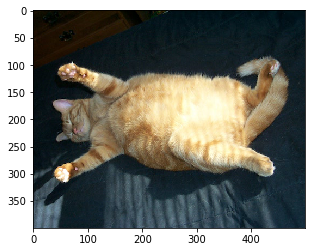

In [2]:
img = plt.imread('./Data/cat1.jpg')
plt.imshow(img)

In [3]:
## 绘图函数
def show_images(imgs, num_rows, num_cols, scale = 2):
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes
def apply(img, aug, num_rows=2, num_cols=4, scale = 1.5):
    Y = [aug(img) for _ in range(num_rows*num_cols)]
    show_images(Y, num_rows, num_cols, scale)

### 翻转和裁剪
右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面通过tf.image.random_flip_left_right来实现一半概率的图像左右翻转。

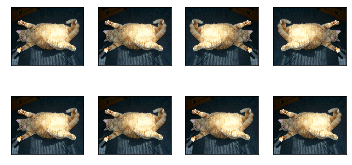

In [4]:
apply(img, tf.image.random_flip_left_right)

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们创建tf.image.random_flip_up_down实例来实现一半概率的图像上下翻转。

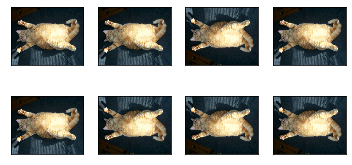

In [5]:
apply(img, tf.image.random_flip_up_down)

除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。

在下面的代码里，我们每次随机裁剪出一块面积为原面积10%∼100%10%∼100%的区域，且该区域的宽和高之比随机取自0.5∼20.5∼2，然后再将该区域的宽和高分别缩放到200像素。若无特殊说明，本节中aa和bb之间的随机数指的是从区间[a,b][a,b]中随机均匀采样所得到的连续值。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F888A9E708>,
      dtype=object)

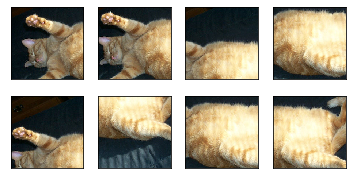

In [6]:
aug = tf.image.random_crop
num_rows = 2
num_cols = 4
scale = 1.5
crop_size = 200

Y = [aug(img, (crop_size, crop_size, 3)) for _ in range(num_cols*num_cols)]
show_images(Y, num_rows, num_cols, scale)

### 变化颜色
另一类增广方法是变化颜色。我们可以从4个方面改变图像的颜色：亮度、对比度、饱和度和色调。在下面的例子里，我们将图像的亮度随机变化为原图亮度的50%50%（即1−0.51−0.5）∼150%∼150%（即1+0.51+0.5）。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F888CDDB88>,
      dtype=object)

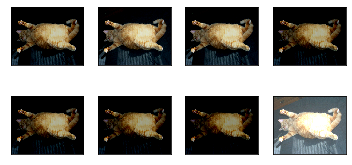

In [7]:
aug=tf.image.random_brightness
num_rows=2
num_cols=4
scale=1.5
max_delta=0.5

Y = [aug(img, max_delta) for _ in range(num_rows * num_cols)]
show_images(Y, num_rows, num_cols, scale)


随机变化图像的色调

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F888997708>,
      dtype=object)

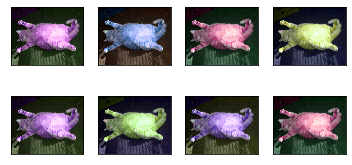

In [8]:
aug=tf.image.random_hue
num_rows=2
num_cols=4
scale=1.5
max_delta=0.5

Y = [aug(img, max_delta) for _ in range(num_rows * num_cols)]
show_images(Y, num_rows, num_cols, scale)


In [ ]:
class Residual(tf.keras.Model):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(num_channels,
                                   padding='same',
                                   kernel_size=3,
                                   strides=strides)
        self.conv2 = layers.Conv2D(num_channels, kernel_size=3,padding='same')
        if use_1x1conv:
            self.conv3 = layers.Conv2D(num_channels,
                                       kernel_size=1,
                                       strides=strides)
        else:
            self.conv3 = None
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, X):
        Y = activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return activations.relu(Y + X)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self,num_channels, num_residuals, first_block=False,**kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.listLayers=[]
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.listLayers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.listLayers.append(Residual(num_channels))      

    def call(self, X):
        for layer in self.listLayers.layers:
            X = layer(X)
        return X

class ResNet(tf.keras.Model):
    def __init__(self,num_blocks,**kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.conv=tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(32, 32,3))
        self.bn=tf.keras.layers.BatchNormalization()
        self.relu=tf.keras.layers.Activation('relu')
        self.mp=tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        self.resnet_block1=ResnetBlock(64,num_blocks[0], first_block=True)
        self.resnet_block2=ResnetBlock(128,num_blocks[1])
        self.resnet_block3=ResnetBlock(256,num_blocks[2])
        self.resnet_block4=ResnetBlock(512,num_blocks[3])
        self.gap=tf.keras.layers.GlobalAvgPool2D()
        self.fc=tf.keras.layers.Dense(units=10,activation=tf.keras.activations.softmax)

    def call(self, x):
        x=self.conv(x)
        x=self.bn(x)
        x=self.relu(x)
        x=self.mp(x)
        x=self.resnet_block1(x)
        x=self.resnet_block2(x)
        x=self.resnet_block3(x)
        x=self.resnet_block4(x)
        x=self.gap(x)
        x=self.fc(x)
        return x
    '''
        # 读取本地gz文档，并转换为numpy矩阵的函数
    def load_localData(self, path):

        path = '/home/brian/Documents/tensorflow-gpu/tensorflow-learning/data/fashion/'

        files = [
              'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
                't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']

        paths = []
        for fname in files:
            paths.append(get_file(fname, origin=None, cache_dir=path + fname, cache_subdir=path))

        with gzip.open(paths[0], 'rb') as lbpath:
            y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

        with gzip.open(paths[1], 'rb') as imgpath:
            x_train = np.frombuffer(\
                imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

        with gzip.open(paths[2], 'rb') as lbpath:
            y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

        with gzip.open(paths[3], 'rb') as imgpath:
            x_test = np.frombuffer(\
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

        return x_train, y_train, x_test, y_test
    '''
    def load_data(self):
        (x, y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
        print(x.shape, test_x.shape)
        #show_images(x[0:4][0], 4, 8, scale = 0.8)
        return x, y, test_x, test_y


In [ ]:
if __name__ == '__main__':
    net = ResNet([2,2,2,2])
    x , y, test_x, test_y = net.load_data()
    x = [tf.image.random_flip_left_right(i) for i in x]

    net.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    #%load_ext tensorboard
    log_dir = './log/resnet_cifar10/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
    with tf.device('/gpu:0'):
        history = net.fit(x, y,
                            batch_size=64,
                            epochs=5,
                            validation_split=0.2, callbacks=[tensorboard_callback])
    net.save('./ModelTrained/ResNet')
    %tensorboard --logdir log/resnet_cifar10
    test_scores = net.evaluate(test_x, test_y, verbose=2)     

(50000, 32, 32, 3) (10000, 32, 32, 3)
